In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime, Stream
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.read_sds import __read_sds
from functions.read_yaml import __readYaml
from functions.smoothing import __smooth
from functions.reduce import __reduce
from functions.interpolate_nan import __interpolate_nan


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
config = {}

config['camera'] = "01"

config['path_to_data'] = data_path+f"ids/"

config['path_to_outdata'] = data_path+f"ids/"

config['path_to_figs'] = data_path+"ids/figures/"

config['detrend'] = True

# conversion from pixel to mm
config['conversion'] = {"XX":1.67e-3,
                        "01":5.3e-3,
                        "03":5.3e-3,
                        "07":5.3e-3,
                       }

# experiment 1 (after setup at RV (S))
# config['ring'] = "V"
# config['date1'] = "2024-07-05 13:00"
# config['date2'] = "2024-07-08 00:00"

# experiment 2 - RV
# config['ring'] = "V"
# config['date1'] = "2024-07-11 00:00"
# config['date2'] = "2024-07-14 00:00"

# experiment 3 - RZ
config['ring'] = "Z"
config['date1'] = "2024-08-10 00:00"
config['date2'] = "2024-08-12 00:00"


config['tbeg'] = UTCDateTime(config['date1'])
config['tend'] = UTCDateTime(config['date2'])

In [5]:
mlti = __load_mlti(config['date1'], config['date2'], "Z", archive_path)
mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [6]:
def __load_beam_wander_data(tbeg, tend, path_to_data, cam):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    path_to_data += f"data{cam}/"

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        print(str(dat)[:10])
        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [7]:
df01 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "01")
df03 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "03")

2024-08-10
2024-08-11
2024-08-12
2024-08-10
2024-08-11
2024-08-12


In [8]:
df01 = df01[df01.time > config['tbeg']]
df03 = df03[df03.time > config['tbeg']]

df01 = df01[df01.time < config['tend']]
df03 = df03[df03.time < config['tend']]

df01.reset_index(inplace=True, drop=True)
df03.reset_index(inplace=True, drop=True)

In [9]:
def __convert(df0, conversion_factor):

    from functions.reduce import __reduce

    # add utc object
    df0['time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0[k] *= conversion_factor

    # to micrometer
    df0['x_um_rel'] = __reduce(df0.x, 50) * 1e3
    df0['y_um_rel'] = __reduce(df0.y, 50) * 1e3

    df0['x_um_sig'] = df0.x_sig * 1e3
    df0['y_um_sig'] = df0.y_sig * 1e3

    df0.reset_index(inplace=True, drop=True)
    return df0

In [10]:
df01 = __convert(df01, config['conversion']["01"])

In [11]:
df03 = __convert(df03, config['conversion']["03"])

In [12]:
def __filter(df0):

    n1 = df0.size

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 20]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0 = df0[df0['amp'] < 255]

    if df0.size != n1:
        df0.reset_index(inplace=True)

    return df0

In [13]:
df01 = __filter(df01)

In [14]:
df03 = __filter(df03)

In [15]:
from scipy.signal import detrend

if config['detrend']:
    df01.y_um_rel = detrend(df01.y_um_rel, type="linear")
    df03.y_um_rel = detrend(df03.y_um_rel, type="linear")

    df01.x_um_rel = detrend(df01.x_um_rel, type="linear")
    df03.x_um_rel = detrend(df03.x_um_rel, type="linear")

### Remove MLTI times

In [16]:
# # turn times with MLTI to NaN
# df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
# df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)


### Load Tilt Data

  -> converted data of ROMYT


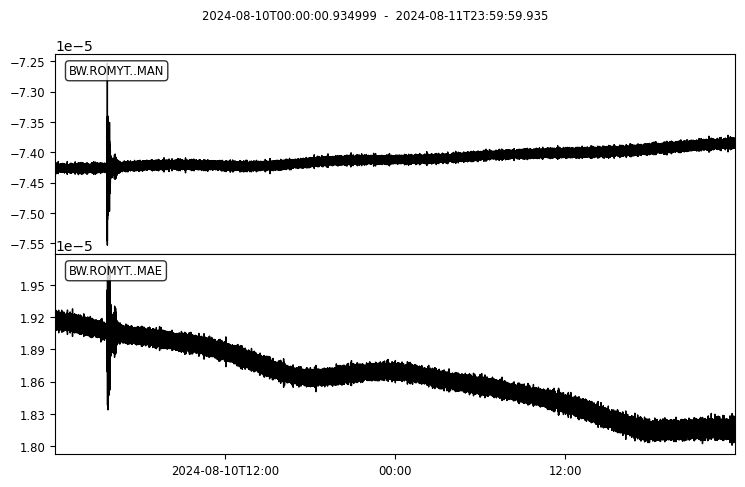

In [17]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

# tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = Stream()
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.decimate(5, no_filter=False)

tromy0 = tromy0.trim(config['tbeg'], config['tend'], nearest_sample=False);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

del tromy0

In [18]:
tromy = tromy.trim(config['tbeg'], config['tend'] - 4*3600)

In [19]:
if config['detrend']:
    tromy = tromy.detrend("linear")

df = tromy.select(channel="*N")[0].stats.sampling_rate

Nsmooth = int(1*df*3600)

tromyN_smooth = __smooth(__reduce(tromy.select(channel="*N")[0].data, 10), Nsmooth)
tromyE_smooth = __smooth(__reduce(tromy.select(channel="*E")[0].data, 10), Nsmooth)

  -> converted data of DROMY


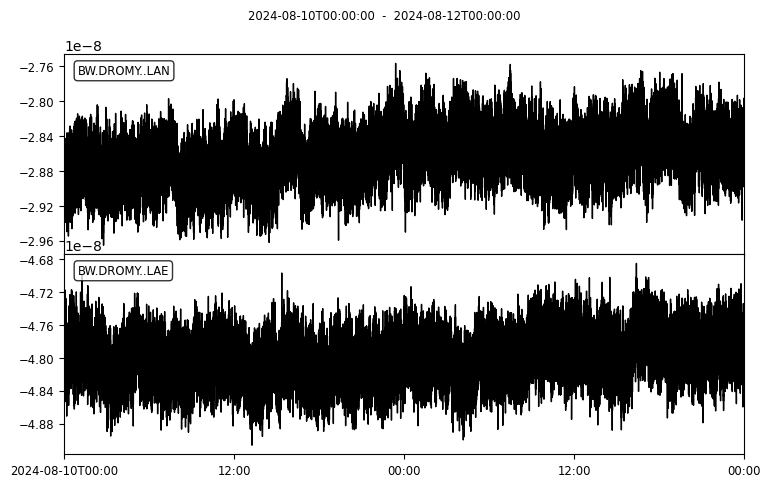

In [20]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

bromy0 = Stream()
bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

bromy0 = __conversion_to_tilt(bromy0, confTilt['BROMY'])

bromy0 = bromy0.decimate(10, no_filter=False)
bromy0 = bromy0.decimate(10, no_filter=False)
bromy0 = bromy0.decimate(2, no_filter=False)

bromy0 = bromy0.trim(config['tbeg'], config['tend'], nearest_sample=False);

bromy0.plot(equal_scale=False);

In [21]:
if config['detrend']:
    bromy0 = bromy0.detrend("linear")

df = bromy0.select(channel="*N")[0].stats.sampling_rate

Nsmooth = int(1*df*3600)

bromyN_smooth = __smooth(__reduce(bromy0.select(channel="*N")[0].data, 10), Nsmooth)
bromyE_smooth = __smooth(__reduce(bromy0.select(channel="*E")[0].data, 10), Nsmooth)

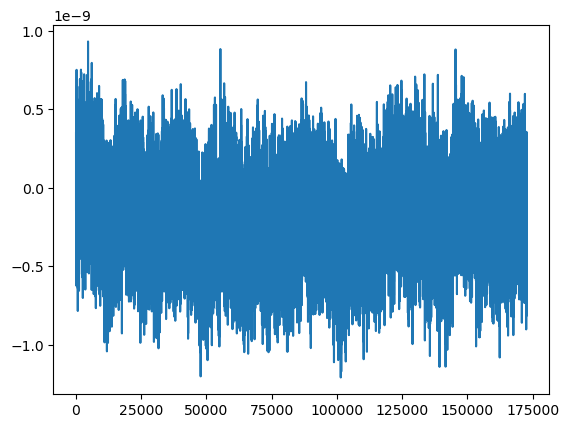

In [22]:
plt.plot(__reduce(bromy0.select(channel="*E")[0].data, 10))

### Load Infrasound FFBI

In [23]:
ffbi = Stream()
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

In [24]:
# ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
# ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

#### Get Hilbert of Pressure

In [25]:
from scipy.signal import hilbert

pp = ffbi.select(channel="*DO").copy()

hp = pp.copy()

if config['detrend']:
    pp = pp.detrend("linear")
    hp = hp.detrend("linear")

for tr in hp:
    NN = int(1e6)
    tr.data = np.pad(tr.data, (NN, NN), mode="edge")

    tr.data = np.imag(hilbert(tr.data))

    tr.data = tr.data[NN:-NN]

# hp = hp.detrend("simple")
# pp = pp.detrend("simple")

for tr in pp:
    tr.data = __reduce(tr.data, 10)
    tr.data += ffbi.select(channel="*DO")[0].data[0]

for tr in hp:
    tr.data = __reduce(tr.data, 10)
    tr.data += ffbi.select(channel="*DO")[0].data[0]

# pp.plot();
# hp.plot();

In [26]:
from functions.load_backscatter_data import __load_backscatter_data
from functions.backscatter_correction import __backscatter_correction
from numpy import unwrap, median

config['path_to_bs_data'] = data_path+"sagnac_frequency/data/backscatter/"

bs = __load_backscatter_data(config['tbeg']-86400, config['tend']+86400, config['ring'], config['path_to_bs_data'], label="")

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

bs['fj_bs'], _, _ = __backscatter_correction(bs.f1_ac / bs.f1_dc,
                                              bs.f2_ac / bs.f2_dc,
                                              unwrap(bs.f1_phw) - unwrap(bs.f2_phw),
                                              bs.w_s,
                                              median(bs.fj_fs),
                                              cm_filter_factor=1.033,
                                             )


mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, 600)

bs = bs[(bs.time1 > config['tbeg']) & (bs.time2 < config['tend'])]


### Plotting

/tmp/ipykernel_237740/2642549084.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tcklbls)


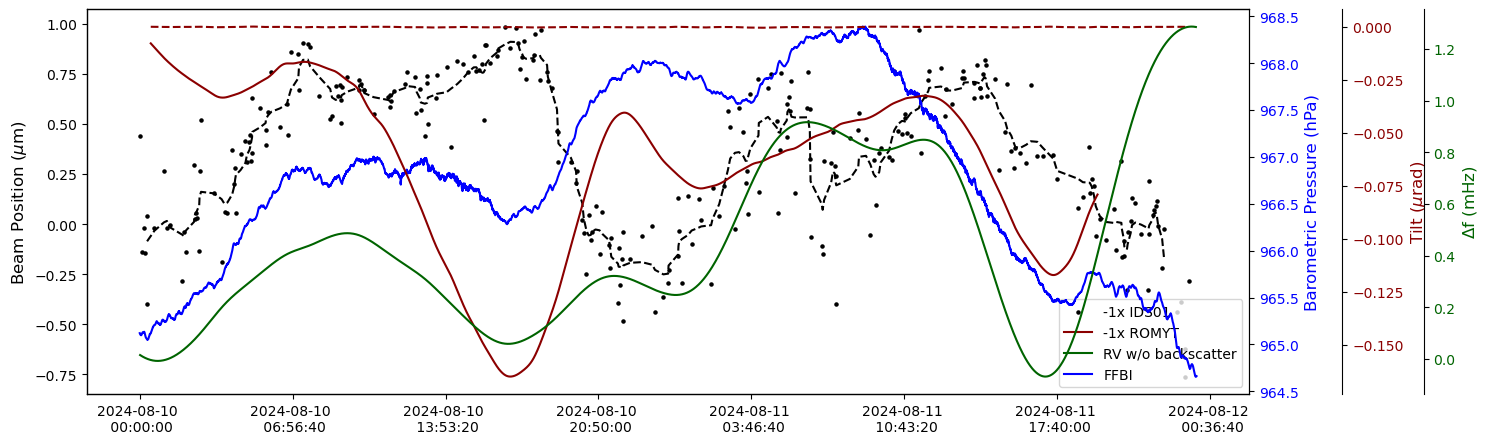

In [27]:
def __makeplot():

    ref_date = config['tbeg']

    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    font = 12

    disp = __reduce(np.sqrt(df01.x_um_rel**2+df01.y_um_rel**2), 10)
    ax1.scatter(df01.time_utc - df01.time_utc.iloc[0],
                -1*disp,
                label=f"-1x IDS01",
                color="k",
                zorder=2,
                s=5,
               )

    ax1.plot(df01.time_utc - df01.time_utc.iloc[0],
              -1*__smooth(disp, 10),
              color="k",
              zorder=2, ls="--"
            )

    # onyl add for legend label
    ax1.plot([], [], color="darkred", label="-1x ROMYT")
    ax1.plot([], [], color="darkgreen", label="RV w/o backscatter")
    ax1.plot([], [], color="blue", label="FFBI")

    # ax1.set_ylim(-3, 3)
    ax1.set_ylabel("Beam Position ($\mu$m)", fontsize=font)

    # ________________________________________________________________________
    ax41 = ax1.twinx()

    NX = 10
    ax41.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
              pp.select(channel="*O")[0].data[::NX],
              color="blue"
              )
    # ax41.plot(hp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
    #           hp.select(channel="*O")[0].data[::NX],
    #           color="blue", ls=":"
    #           )

    ax41.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
    [t.set_color('blue') for t in ax41.yaxis.get_ticklabels()]

    # ________________________________________________________________________
    ax2 = ax1.twinx()

    NX = 1

    tilt = np.sqrt(tromyE_smooth**2+tromyN_smooth**2)*1e6
    ax2.plot(tromy.select(component="E")[0].times(reftime=ref_date)[::NX],
             -1*tilt[::NX], color="darkred"
            )

    tilt2 = np.sqrt(bromyE_smooth**2+bromyN_smooth**2)*1e6
    ax2.plot(bromy0.select(component="E")[0].times(reftime=ref_date)[::NX],
             -1*tilt2[::NX], color="darkred", ls="--"
            )

    # ax2.set_ylim(-.8, .8)
    ax2.spines.right.set_position(("axes", 1.08))
    ax2.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax2.yaxis.get_ticklabels()]

    ax1.legend(loc=4)

    # ________________________________________________________________________
    ax51 = ax1.twinx()

    ax51.plot(bs.time1 - config['tbeg'],
              (bs.fj_bs_smooth - np.nanmean(bs.fj_bs_smooth[:100]))*1e3,
              color="darkgreen"
              )

    # ax51.set_ylim(-2.5, .5)
    ax51.spines.right.set_position(("axes", 1.15))
    ax51.set_ylabel("$\Delta$f (mHz)", fontsize=font, color="darkgreen")
    [t.set_color('darkgreen') for t in ax51.yaxis.get_ticklabels()]

    # ________________________________________________________________________

    # add dates to x-axis
    tcks = ax1.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax1.set_xticklabels(tcklbls)

    return fig

fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"BW_RZ_environmentals_{config['tbeg'].date}_{config['tend'].date}_detrend.png", format="png", dpi=150, bbox_inches='tight')


/tmp/ipykernel_237740/4264610598.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax21.set_xticklabels(tcklbls)


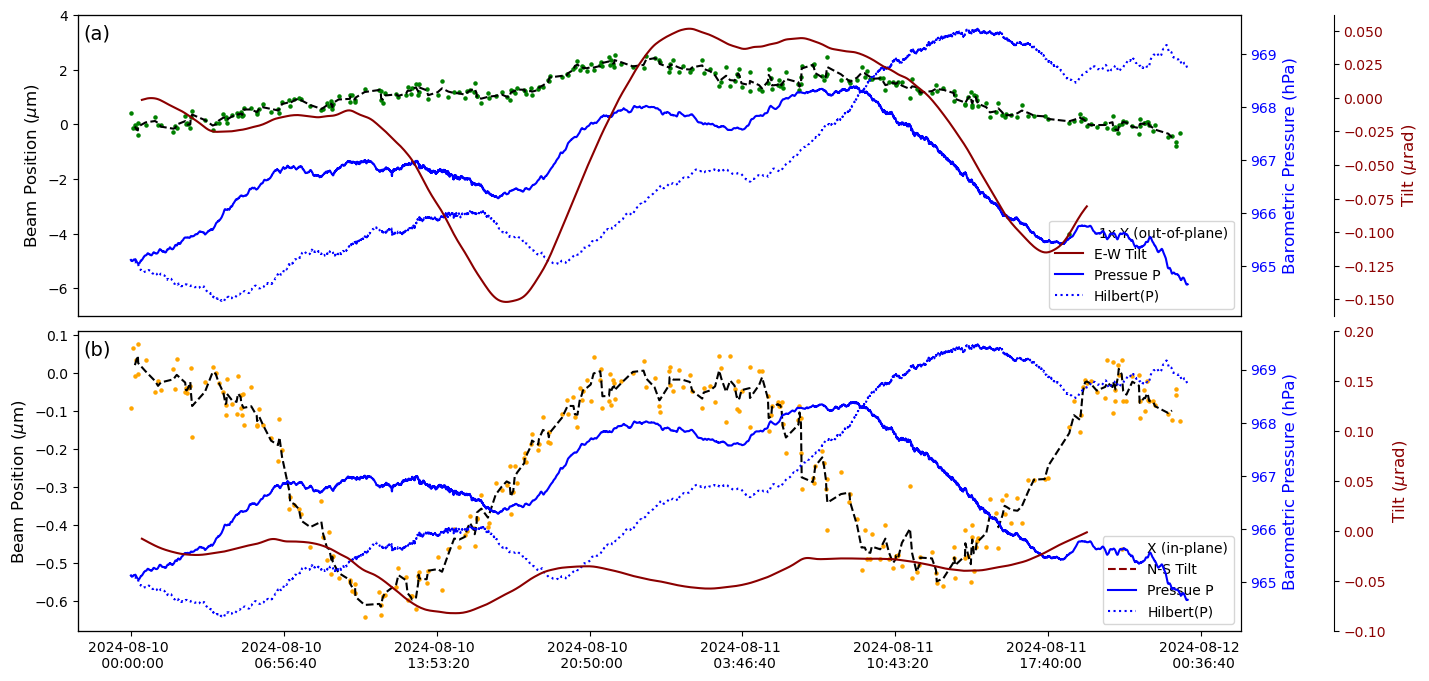

In [28]:
def __makeplot():

    ref_date = config['tbeg']

    fig, (ax11, ax21) = plt.subplots(2, 1, figsize=(15, 8))

    font = 12

    plt.subplots_adjust(hspace=0.05)

    ax11.scatter(df01.time_utc - df01.time_utc.iloc[0],
                -1*__reduce(df01.y_um_rel, 10),
                label=f"-1x Y (out-of-plane)",
                color="green",
                zorder=2,
                s=5,
               )

    ax11.plot(df01.time_utc - df01.time_utc.iloc[0],
              -1*__smooth(__reduce(df01.y_um_rel, 10), 5),
              # label=f"X (in-plane)",
              color="k",
              zorder=2, ls="--"
              )
    ax11.set_ylim(-7, 4)

    ax21.scatter(df01.time_utc - df01.time_utc.iloc[0],
                __reduce(df01.x_um_rel, 10),
                label=f"X (in-plane)",
                color="orange",
                zorder=2,
                s=5,
               )

    ax21.plot(df01.time_utc - df01.time_utc.iloc[0],
              __smooth(__reduce(df01.x_um_rel, 10), 5),
              # label=f"X (in-plane)",
              color="k",
              zorder=2, ls="--"
              )

    # ax11.scatter(df03.time_utc - df03.time_utc.iloc[0],
    #             -1*__reduce(df03.y_um_rel, 10),
    #             label=f"-1x Y (out-of-plane)",
    #             color="green",
    #             zorder=2,
    #             s=5,
    #            )
    # ax21.scatter(df03.time_utc - df03.time_utc.iloc[0],
    #             __reduce(df03.x_um_rel, 10),
    #             label=f"X (in-plane)",
    #             color="orange",
    #             zorder=2,
    #             s=5,
    #
    # __________________________________________________
    # onyl add for legend label
    ax11.plot(tromy.select(component="E")[0].times(reftime=ref_date),
              tromyE_smooth*np.nan, color="darkred", label="E-W Tilt")
    ax11.plot(pp.select(channel="*O")[0].times(reftime=ref_date),
              pp.select(channel="*O")[0].data*np.nan, color="blue", label="Pressue P")
    ax11.plot(hp.select(channel="*O")[0].times(reftime=ref_date),
              hp.select(channel="*O")[0].data*np.nan, color="blue", ls=":", label="Hilbert(P)")
    ax21.plot(tromy.select(component="N")[0].times(reftime=config['tbeg'])[::150],
              tromyN_smooth[::150]*np.nan, color="darkred", ls="--", label="N-S Tilt")
    ax21.plot(pp.select(channel="*O")[0].times(reftime=ref_date),
              pp.select(channel="*O")[0].data*np.nan, color="blue", label="Pressue P")
    ax21.plot(hp.select(channel="*O")[0].times(reftime=ref_date),
              hp.select(channel="*O")[0].data*np.nan, color="blue", ls=":", label="Hilbert(P)")

    # ax1.set_ylim(-8, 3)
    ax11.set_ylabel("Beam Position ($\mu$m)", fontsize=font)
    ax21.set_ylabel("Beam Position ($\mu$m)", fontsize=font)

    # __________________________________________________
    ax41 = ax11.twinx()
    NX = 10
    ax41.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
              pp.select(channel="*O")[0].data[::NX],
              color="blue"
              )
    ax41.plot(hp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
              hp.select(channel="*O")[0].data[::NX],
              color="blue", ls=":"
              )
    ax41.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
    [t.set_color('blue') for t in ax41.yaxis.get_ticklabels()]

    # __________________________________________________
    ax42 = ax21.twinx()
    NX = 10
    ax42.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
              pp.select(channel="*O")[0].data[::NX],
              color="blue"
              )
    ax42.plot(hp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
              hp.select(channel="*O")[0].data[::NX],
              color="blue", ls=":"
              )
    ax42.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
    [t.set_color('blue') for t in ax42.yaxis.get_ticklabels()]

    # __________________________________________________
    ax112 = ax11.twinx()

    NX = 300
    ax112.plot(tromy.select(component="E")[0].times(reftime=ref_date)[::NX],
             tromyE_smooth[::NX]*1e6, color="darkred"
            )
    ax112.spines.right.set_position(("axes", 1.08))
    ax112.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax112.yaxis.get_ticklabels()]

    ax11.legend(loc=4)
    ax21.legend(loc=4)

    # __________________________________________________
    ax212 = ax21.twinx()

    NX = 300
    ax212.plot(tromy.select(component="N")[0].times(reftime=config['tbeg'])[::NX],
             tromyN_smooth[::NX]*1e6, color="darkred", ls="-"
            )
    ax212.set_ylim(-.1, .2)
    ax212.spines.right.set_position(("axes", 1.08))
    ax212.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax212.yaxis.get_ticklabels()]

    ax11.legend(loc=4)
    ax21.legend(loc=4)

    ax11.get_xaxis().set_visible(False)

    axes = [ax11, ax21]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    # add dates to x-axis
    tcks = ax21.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax21.set_xticklabels(tcklbls)

    return fig

fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"BW_RZ_environmentals2_{config['tbeg'].date}_{config['tend'].date}_detrend.png", format="png", dpi=150, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


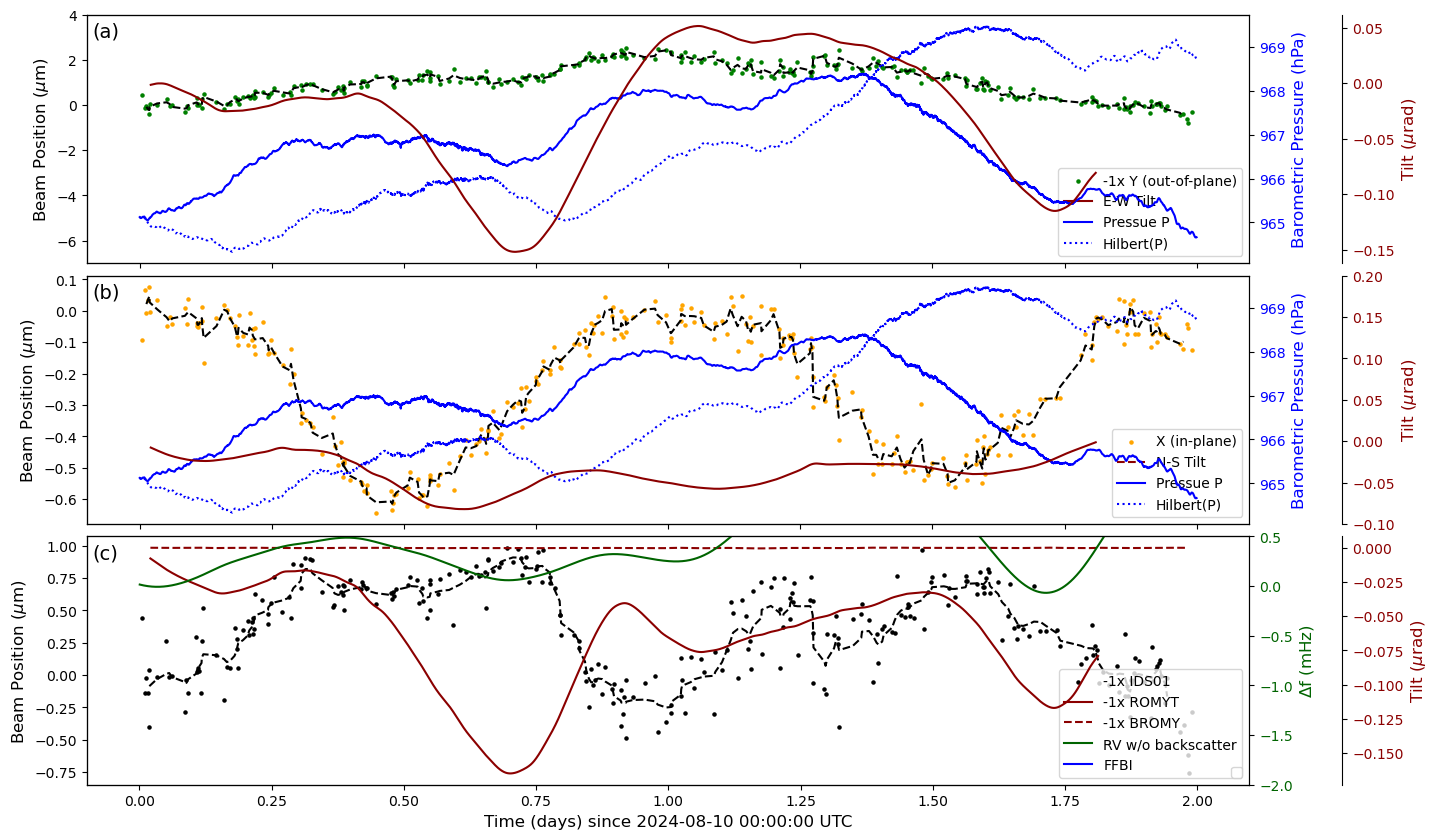

In [29]:
def __makeplot():

    ref_date = config['tbeg']

    fig, (ax11, ax21, ax31) = plt.subplots(3, 1, figsize=(15, 10))

    font = 12

    tscale, tunit = 1/86400, "days"

    plt.subplots_adjust(hspace=0.05)

    ax11.scatter((df01.time_utc - ref_date)*tscale,
                -1*__reduce(df01.y_um_rel, 10),
                label=f"-1x Y (out-of-plane)",
                color="green",
                zorder=2,
                s=5,
               )

    ax11.plot((df01.time_utc - ref_date)*tscale,
              -1*__smooth(__reduce(df01.y_um_rel, 10), 5),
              # label=f"X (in-plane)",
              color="k",
              zorder=2, ls="--"
              )

    ax11.set_ylim(-7, 4)

    ax21.scatter((df01.time_utc - ref_date)*tscale,
                __reduce(df01.x_um_rel, 10),
                label=f"X (in-plane)",
                color="orange",
                zorder=2,
                s=5,
               )

    ax21.plot((df01.time_utc - ref_date)*tscale,
              __smooth(__reduce(df01.x_um_rel, 10), 5),
              # label=f"X (in-plane)",
              color="k",
              zorder=2, ls="--"
              )

    # onyl add for legend label
    ax11.plot(tromy.select(component="E")[0].times(reftime=ref_date)*tscale,
              tromyE_smooth*np.nan, color="darkred", label="E-W Tilt")
    ax11.plot(pp.select(channel="*O")[0].times(reftime=ref_date)*tscale,
              pp.select(channel="*O")[0].data*np.nan, color="blue", label="Pressue P")
    ax11.plot(hp.select(channel="*O")[0].times(reftime=ref_date)*tscale,
              hp.select(channel="*O")[0].data*np.nan, color="blue", ls=":", label="Hilbert(P)")

    ax21.plot(tromy.select(component="N")[0].times(reftime=ref_date)*tscale,
              tromyN_smooth*np.nan, color="darkred", ls="--", label="N-S Tilt")
    ax21.plot(pp.select(channel="*O")[0].times(reftime=ref_date)*tscale,
              pp.select(channel="*O")[0].data*np.nan, color="blue", label="Pressue P")
    ax21.plot(hp.select(channel="*O")[0].times(reftime=ref_date)*tscale,
              hp.select(channel="*O")[0].data*np.nan, color="blue", ls=":", label="Hilbert(P)")

    # __________________________________________________
    ax41 = ax11.twinx()
    NX = 10
    ax41.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX]*tscale,
              pp.select(channel="*O")[0].data[::NX],
              color="blue"
              )
    ax41.plot(hp.select(channel="*O")[0].times(reftime=ref_date)[::NX]*tscale,
              hp.select(channel="*O")[0].data[::NX],
              color="blue", ls=":"
              )
    ax41.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
    [t.set_color('blue') for t in ax41.yaxis.get_ticklabels()]

    # __________________________________________________
    ax42 = ax21.twinx()
    NX = 10

    ax42.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX]*tscale,
              pp.select(channel="*O")[0].data[::NX],
              color="blue"
              )
    ax42.plot(hp.select(channel="*O")[0].times(reftime=ref_date)[::NX]*tscale,
              hp.select(channel="*O")[0].data[::NX],
              color="blue", ls=":"
              )

    ax42.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
    [t.set_color('blue') for t in ax42.yaxis.get_ticklabels()]

    # __________________________________________________
    ax112 = ax11.twinx()

    NX = 300
    ax112.plot(tromy.select(component="E")[0].times(reftime=ref_date)[::NX]*tscale,
             tromyE_smooth[::NX]*1e6, color="darkred"
            )

    ax112.spines.right.set_position(("axes", 1.08))
    ax112.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax112.yaxis.get_ticklabels()]

    ax11.legend(loc=4)
    ax21.legend(loc=4)

    # __________________________________________________
    ax212 = ax21.twinx()

    NX = 300
    ax212.plot(tromy.select(component="N")[0].times(reftime=ref_date)[::NX]*tscale,
             tromyN_smooth[::NX]*1e6, color="darkred", ls="-"
            )

    ax212.set_ylim(-.1, .2)
    ax212.spines.right.set_position(("axes", 1.08))
    ax212.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax212.yaxis.get_ticklabels()]

    ax11.legend(loc=4)
    ax21.legend(loc=4)

    # __________________________________________________

    disp = __reduce(np.sqrt(df01.x_um_rel**2+df01.y_um_rel**2), 10)
    ax31.scatter((df01.time_utc - ref_date)*tscale,
                -1*disp,
                label=f"-1x IDS01",
                color="k",
                zorder=2,
                s=5,
               )

    ax31.plot((df01.time_utc - ref_date)*tscale,
              -1*__smooth(disp, 10),
              color="k",
              zorder=2, ls="--"
            )

    # onyl add for legend label
    ax31.plot([], [], color="darkred", label="-1x ROMYT")
    ax31.plot([], [], color="darkred", label="-1x BROMY", ls="--")
    ax31.plot([], [], color="darkgreen", label="RV w/o backscatter")
    ax31.plot([], [], color="blue", label="FFBI")
    ax31.legend(loc=4)

    # __________________________________________
#     ax311 = ax31.twinx()

#     NX = 10
#     ax311.plot(pp.select(channel="*O")[0].times(reftime=ref_date)[::NX],
#               pp.select(channel="*O")[0].data[::NX],
#               color="blue"
#               )

#     ax311.set_ylabel("Barometric Pressure (hPa)", fontsize=font, color="blue")
#     [t.set_color('blue') for t in ax41.yaxis.get_ticklabels()]

    # __________________________________________
    ax312 = ax31.twinx()

    NX = 1

    tilt = np.sqrt(tromyE_smooth**2+tromyN_smooth**2)*1e6
    ax312.plot(tromy.select(component="E")[0].times(reftime=ref_date)[::NX]*tscale,
             -1*tilt[::NX], color="darkred"
            )

    tilt2 = np.sqrt(bromyE_smooth**2+bromyN_smooth**2)*1e6
    ax312.plot(bromy0.select(component="E")[0].times(reftime=ref_date)[::NX]*tscale,
             -1*tilt2[::NX], color="darkred", ls="--",
            )

    # ax2.set_ylim(-.8, .8)
    ax312.spines.right.set_position(("axes", 1.08))
    ax312.set_ylabel("Tilt ($\mu$rad)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax312.yaxis.get_ticklabels()]

    ax312.legend(loc=4)

    # __________________________________________
    ax313 = ax31.twinx()

    ax313.plot((bs.time1 - ref_date)*tscale,
              (bs.fj_bs_smooth - np.nanmean(bs.fj_bs_smooth[:100]))*1e3,
              color="darkgreen"
              )

    ax313.set_ylim(-2., .5)
    # ax313.spines.right.set_position(("axes", 1.15))
    ax313.set_ylabel("$\Delta$f (mHz)", fontsize=font, color="darkgreen")
    [t.set_color('darkgreen') for t in ax313.yaxis.get_ticklabels()]

    # __________________________________________

    ax11.set_ylabel("Beam Position ($\mu$m)", fontsize=font)
    ax21.set_ylabel("Beam Position ($\mu$m)", fontsize=font)
    ax31.set_ylabel("Beam Position ($\mu$m)", fontsize=font)

    ax11.set_xticklabels([])
    ax21.set_xticklabels([])

    # add labels
    axes = [ax11, ax21, ax31]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    # add dates to x-axis
    # tcks = ax31.get_xticks()
    # tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {str(UTCDateTime(UTCDateTime(ref_date)+t).time)[:8]}" for t in tcks]
    # ax31.set_xticklabels(tcklbls)

    ax31.set_xlabel(f"Time (days) since {config['tbeg'].date} {str(config['tbeg'].time)[:8]} UTC", fontsize=font)

    return fig

fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"BW_RZ_environmentals3_{config['tbeg'].date}_{config['tend'].date}_detrend.png", format="png", dpi=150, bbox_inches='tight')


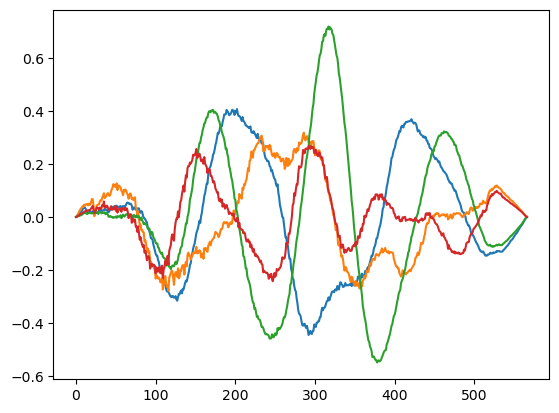

In [30]:
from obspy.signal.cross_correlation import correlate

tt = tromy[0].times()
EE = tromy.select(channel="*E")[0].data
NN = tromy.select(channel="*N")[0].data

bwy = df01.y_um_rel
bwx = df01.x_um_rel

tiltEE = np.interp(df01.time_sec, tt, EE)
tiltNN = np.interp(df01.time_sec, tt, NN)

cc = correlate(tiltEE, bwy, shift=len(bwy))
plt.plot(cc)
cc = correlate(tiltNN, bwy, shift=len(bwy))
plt.plot(cc)
cc = correlate(tiltEE, bwx, shift=len(bwy))
plt.plot(cc)
cc = correlate(tiltNN, bwx, shift=len(bwy))
plt.plot(cc)